**Table of contents**<a id='toc0_'></a>    
1. [Estudio sobre datos de **AirBnB** de la ciudad de Porto y alrededores.](#toc1_)    
1.1. [Importación de librerías, visualización y tratamientos de los dataset](#toc1_1_)    
1.2. [Tratamiento de datos con KNN](#toc1_2_)    
1.3. [Análisis exploratorio](#toc1_3_)    
1.4. [Filtro de distancias](#toc1_4_)    
1.4.1. [Vecindario (IGUAL NO DEBO PONER VECINDARIO sino parroquias o alguo así: freguesia)](#toc1_4_1_)    
1.4.2. [Mapa de la localización de los alojamientos](#toc1_4_2_)    
1.5. [Tipos de propiedades y habitaciones](#toc1_5_)    
1.5.1. [Tipos de habitaciones](#toc1_5_1_)    
1.5.2. [Tipos de propiedades](#toc1_5_2_)    
1.6. [Número de alojados](#toc1_6_)    
1.7. [Analítica al servicio del gobierno. (PENDIENTE DE REVISAR LA LEY DE OPORTO )](#toc1_7_)    
1.8. [Consejos al turismo](#toc1_8_)    
1.8.1. [Precio medio por vecindario](#toc1_8_1_)    
1.8.1.1. [Mapa del precio medio por localizaciones](#toc1_8_1_1_)    
1.8.1.2. [Veamos el tipo de vivienda a alquilar por colores y localizaciones](#toc1_8_1_2_)    
1.8.1.3. [Qué áreas de Oporto serán las más rentables para alquilar](#toc1_8_1_3_)    
1.8.1.4. [Mapa de calor con los precios más altos](#toc1_8_1_4_)    
1.8.2. [Sobre la movidita de los pisos de AirBnB en Portugal.](#toc1_8_2_)    
1.8.3. [Seguridad del vecindario](#toc1_8_3_)    
1.8.4. [Review scores location, and location scores versus price](#toc1_8_4_)    
1.9. [Cómo usar las puntuaciones de las opiniones](#toc1_9_)    
1.9.1. [Encontrando un buen hospedador](#toc1_9_1_)    
1.10. [Disponibilidad en el tiempo](#toc1_10_)    
1.10.1. [Precio medio por día](#toc1_10_1_)    
1.11. [MInería de texto con las reviews](#toc1_11_)    
1.12. [Predicción de sentimientos](#toc1_12_)    
1.12.1. [Vamos a emplear la columna review_scores_accuracy para segregar los sentimientos.](#toc1_12_1_)    
1.12.2. [Analizando las notas](#toc1_12_2_)    
1.12.3. [Decision Tree Classifier](#toc1_12_3_)    
1.13. [Modelos predictivos para predecir el valor de tu alojamiento en Oporto.](#toc1_13_)    
1.13.1. [Fast Machine Learning con Pycaret -> Claramente no sé usar Pycaret.](#toc1_13_1_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=true
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# 1. <a id='toc1_'></a>[Estudio sobre datos de **AirBnB** de la ciudad de Porto y alrededores.](#toc0_)

## 1.1. <a id='toc1_1_'></a>[Importación de librerías, visualización y tratamientos de los dataset](#toc0_)

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
from utils.funciones import *
import os
import json
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# mapas interactivos
import folium
from folium.plugins import FastMarkerCluster, FloatImage
import geopandas as gpd
from branca.colormap import LinearColormap
from folium.plugins import HeatMap, MarkerCluster
#to make the plotly graphs
import plotly.graph_objs as go
import plotly_express as px
import chart_studio.plotly as py
import plotly.subplots as sp
import cufflinks
import plotly.io as pio 
#text mining
import nltk
from nltk.tokenize import word_tokenize

from nltk.corpus import stopwords
import re
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from wordcloud import WordCloud

from prettymapp.geo import get_aoi
from prettymapp.osm import get_osm_geometries
from prettymapp.plotting import Plot
from prettymapp.settings import STYLES


In [6]:
plot = prettymaps.plot(
    'Porto, Portugal',
    circle = True,
    radius = 1288,
  "name_on": true,
  "name": "porto",
  "font_size": 25,
  "font_color": "#2F3737",
  "text_x": 16,
  "text_y": -40,
  "text_rotation": -18,
  "shape": "circle",
  "contour_width": 1,
  "contour_color": "#2F3537",
  "bg_shape": "circle",
  "bg_buffer": 2,
  "bg_color": "#F2F4CB"
    layers = {
  "address": "porto, portugal ",
  "aoi_bounds": [
    -8.626137610959043,
    41.13784914640842,
    -8.595439229129454,
    41.16105323005113
  ],
  "draw_settings": {
    "urban": {
      "cmap": [
        "#FFC857",
        "#E9724C",
        "#C5283D"
      ],
      "ec": "#2F3737",
      "lw": 0.5,
      "zorder": 4
    },
    "water": {
      "fc": "#a1e3ff",
      "ec": "#85c9e6",
      "hatch": "ooo...",
      "hatch_c": "#2F3737",
      "lw": 1,
      "zorder": 1
    },
    "grassland": {
      "fc": "#D0F1BF",
      "ec": "#2F3737",
      "lw": 1,
      "zorder": 2
    },
    "woodland": {
      "fc": "#64B96A",
      "ec": "#2F3737",
      "lw": 1,
      "zorder": 2
    },
    "streets": {
      "fc": "#2F3737",
      "zorder": 3
    },
    "other": {
      "fc": "#F2F4CB",
      "ec": "#2F3737",
      "lw": 1,
      "zorder": 3
    }
  }
}
)

SyntaxError: positional argument follows keyword argument (508272484.py, line 5)

In [2]:
df_calendar = pd.read_csv('http://data.insideairbnb.com/portugal/norte/porto/2022-12-16/data/calendar.csv.gz', parse_dates=['date'], index_col=['listing_id'])
#df_calendar.to_csv('input/calendar.csv', index=False)

In [3]:
df_listing_detailed = pd.read_csv('http://data.insideairbnb.com/portugal/norte/porto/2022-12-16/data/listings.csv.gz', index_col= ["id"])
df_listing_detailed.to_csv('output/listings_detailed.csv', index=False)

In [4]:
df_reviews = pd.read_csv('http://data.insideairbnb.com/portugal/norte/porto/2022-12-16/data/reviews.csv.gz', parse_dates=['date'])
#df_reviews.to_csv('input/reviews.csv', index=False)

In [5]:
df_listing = pd.read_csv('http://data.insideairbnb.com/portugal/norte/porto/2022-12-16/visualisations/listings.csv', index_col= ["id"])
df_listing.to_csv('output/listings.csv', index=False)

In [6]:
df_listing_detailed['price'] = df_listing_detailed['price'].replace('[$,]', '', regex=True)
df_listing_detailed['price'] = df_listing_detailed['price'].astype(float).round().astype(int)

In [7]:
df_oporto_review = df_listing # Copio el df aquí para usar las review después en la sección de la Nube de palabras

In [8]:
df_listing_detailed.head()

,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,host_url,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
id,,,,,,,,,,,,,,,,,,,,,
41339,https://www.airbnb.com/rooms/41339,20221216161338,2022-12-17,city scrape,Porto city flat near the sea,Here you'll find all you need for your holiday...,In the surrounds you have Serralves Museum and...,https://a0.muscache.com/pictures/25727334/9578...,180050,https://www.airbnb.com/users/show/180050,...,4.80,4.55,4.65,29049/AL,f,1,1,0,0,0.17
55111,https://www.airbnb.com/rooms/55111,20221216161338,2022-12-17,previous scrape,Fontielas Houses |Floor1 in House with shared ...,Is the first floor in a villa with shared pool...,NaN,https://a0.muscache.com/pictures/b3c38006-5fdf...,259711,https://www.airbnb.com/users/show/259711,...,4.87,4.79,4.79,7563/AL,f,3,3,0,0,0.17
73828,https://www.airbnb.com/rooms/73828,20221216161338,2022-12-17,previous scrape,Fontielas Houses |Floor0 in House with shared ...,Ground floor in a villa with shared pool and p...,NaN,https://a0.muscache.com/pictures/ffb19299-425c...,259711,https://www.airbnb.com/users/show/259711,...,5.00,4.92,4.75,7563/AL,f,3,3,0,0,0.13
86388,https://www.airbnb.com/rooms/86388,20221216161338,2022-12-16,city scrape,A Formosa - a nest made for two,<b>The space</b><br />A big and bright bedroo...,NaN,https://a0.muscache.com/pictures/850099/b80470...,185209,https://www.airbnb.com/users/show/185209,...,4.93,4.87,4.76,6995/AL,f,8,2,6,0,1.37
87873,https://www.airbnb.com/rooms/87873,20221216161338,2022-12-17,city scrape,Oporto Apartment Triplex,- Cozy apartment with great sun exposition<br ...,OPorto Apartment Triplex is located on Rua San...,https://a0.muscache.com/pictures/33686513/c54f...,480980,https://www.airbnb.com/users/show/480980,...,4.94,4.51,4.81,634/AL,f,3,1,2,0,1.74


In [9]:
df_listing_detailed.columns

Index(['listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'calendar

Aquí lo que hago es un left outer join, seguido de un right outer join en el que se excluyan las columnas que ya se han unido en el left join para evitar la duplicación. Con un merge tan solo de pandas no funciona. 

Seleccionamos las columnas con las que vamos a trabajar.

In [10]:
df_listing.columns


Index(['name', 'host_id', 'host_name', 'neighbourhood_group', 'neighbourhood',
       'latitude', 'longitude', 'room_type', 'price', 'minimum_nights',
       'number_of_reviews', 'last_review', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365',
       'number_of_reviews_ltm', 'license'],
      dtype='object')

In [11]:
target_columns = ["accommodates", "host_is_superhost", "host_response_rate", "host_response_time", "listing_url",  "maximum_nights",  "property_type", "review_scores_accuracy", "review_scores_checkin", "review_scores_cleanliness", "review_scores_communication", "review_scores_location", "review_scores_rating", "review_scores_value"]

# "host_about",

In [12]:
oporto_merge = pd.merge(df_listing, df_listing_detailed[target_columns], on= 'id', how='left')

cols = df_listing.columns

oporto = oporto_merge

oportopreknn = oporto.to_csv('output/oportopreknn.csv')
# ! Este csv está para ver que una vez se ha hecho el merge ya aparecen los errores en las columnas. A partir de cierto valor parece que una fila se convierte en dos dejando las columnas del final de dicha línea sin rellenar y empezando a rellenar por las columnas del principio de la fila siguiente con las columnas del final de la línea que ha cortado.
oporto.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12013 entries, 41339 to 779861992110623008
Data columns (total 31 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   name                            12013 non-null  object 
 1   host_id                         12013 non-null  int64  
 2   host_name                       12009 non-null  object 
 3   neighbourhood_group             12013 non-null  object 
 4   neighbourhood                   12013 non-null  object 
 5   latitude                        12013 non-null  float64
 6   longitude                       12013 non-null  float64
 7   room_type                       12013 non-null  object 
 8   price                           12013 non-null  int64  
 9   minimum_nights                  12013 non-null  int64  
 10  number_of_reviews               12013 non-null  int64  
 11  last_review                     10714 non-null  object 
 12  reviews_per_mon

In [13]:
oporto.isnull().sum()

name                                 0
host_id                              0
host_name                            4
neighbourhood_group                  0
neighbourhood                        0
latitude                             0
longitude                            0
room_type                            0
price                                0
minimum_nights                       0
number_of_reviews                    0
last_review                       1299
reviews_per_month                 1299
calculated_host_listings_count       0
availability_365                     0
number_of_reviews_ltm                0
license                            678
accommodates                         0
host_is_superhost                    0
host_response_rate                2030
host_response_time                2030
listing_url                          0
maximum_nights                       0
property_type                        0
review_scores_accuracy            1328
review_scores_checkin    

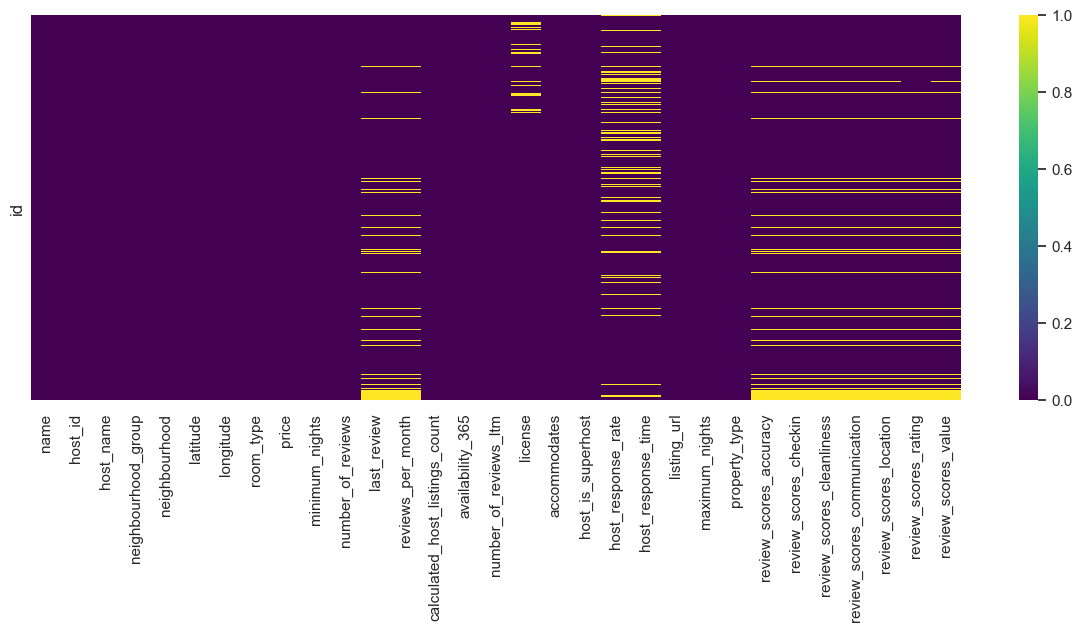

In [14]:
plt.figure(figsize=(15, 5))
sns.heatmap(oporto.isnull(), yticklabels=False, cbar=True, cmap="viridis");

In [15]:
oporto[['host_id', 'price', 'minimum_nights', 'number_of_reviews', 'calculated_host_listings_count',    'availability_365', 'number_of_reviews_ltm', 'accommodates', 'maximum_nights']] = oporto[['host_id', 'price', 'minimum_nights', 'number_of_reviews', 'calculated_host_listings_count',                                                                                                 'availability_365', 'number_of_reviews_ltm', 'accommodates', 'maximum_nights']].astype(int)
oporto['host_response_rate'] = oporto['host_response_rate'].str.replace('%', '').fillna(0) #cambiamos los NaN por 0
oporto['host_response_rate'] = oporto['host_response_rate'].astype(int)
# oporto['last_review'] = pd.to_datetime(oporto['last_review'], format='%Y-%m-%d')
# oporto['first_review'] = pd.to_datetime(oporto['first_review'], format='%Y-%m-%d') 
#! convertir aquí las columnas temporales da error en el KNN hacer después

In [16]:
oporto.head()

,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,...,listing_url,maximum_nights,property_type,review_scores_accuracy,review_scores_checkin,review_scores_cleanliness,review_scores_communication,review_scores_location,review_scores_rating,review_scores_value
id,,,,,,,,,,,,,,,,,,,,,
41339,Porto city flat near the sea,180050,Paula,PORTO,Lordelo do Ouro e Massarelos,41.15010,-8.66035,Entire home/apt,60,2,...,https://www.airbnb.com/rooms/41339,120,Entire rental unit,4.70,4.85,4.90,4.80,4.55,4.70,4.65
55111,Fontielas Houses |Floor1 in House with shared ...,259711,Isabel E João,PAREDES,Cete,41.17481,-8.35362,Entire home/apt,66,3,...,https://www.airbnb.com/rooms/55111,60,Entire rental unit,4.80,4.87,4.67,4.87,4.79,4.80,4.79
73828,Fontielas Houses |Floor0 in House with shared ...,259711,Isabel E João,PAREDES,Cete,41.17449,-8.35426,Entire home/apt,66,5,...,https://www.airbnb.com/rooms/73828,60,Entire rental unit,5.00,5.00,4.83,5.00,4.92,4.83,4.75
86388,A Formosa - a nest made for two,185209,João,PORTO,"Cedofeita, Ildefonso, Sé, Miragaia, Nicolau, V...",41.14918,-8.60922,Private room,33,2,...,https://www.airbnb.com/rooms/86388,31,Private room in rental unit,4.76,4.93,4.65,4.93,4.87,4.74,4.76
87873,Oporto Apartment Triplex,480980,Paula,PORTO,Bonfim,41.15786,-8.60427,Entire home/apt,64,3,...,https://www.airbnb.com/rooms/87873,14,Entire rental unit,4.87,4.97,4.89,4.94,4.51,4.79,4.81


## 1.2. <a id='toc1_2_'></a>[Tratamiento de datos con KNN](#toc0_)

In [17]:
oporto.duplicated().sum()

0

In [18]:
oporto.columns

Index(['name', 'host_id', 'host_name', 'neighbourhood_group', 'neighbourhood',
       'latitude', 'longitude', 'room_type', 'price', 'minimum_nights',
       'number_of_reviews', 'last_review', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365',
       'number_of_reviews_ltm', 'license', 'accommodates', 'host_is_superhost',
       'host_response_rate', 'host_response_time', 'listing_url',
       'maximum_nights', 'property_type', 'review_scores_accuracy',
       'review_scores_checkin', 'review_scores_cleanliness',
       'review_scores_communication', 'review_scores_location',
       'review_scores_rating', 'review_scores_value'],
      dtype='object')

In [19]:
df_encoded, encoded_info = fritas(oporto)

In [20]:
target_column = "price"
bestkar = bravas(df_encoded, target_column)

In [21]:
bestkar

3

In [22]:
df_imputed = impute_missing_values_with_knn(df_encoded, bestkar)

In [23]:
df_imputed.isnull().sum()

name                              0
host_id                           0
host_name                         0
neighbourhood_group               0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
last_review                       0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
number_of_reviews_ltm             0
license                           0
accommodates                      0
host_is_superhost                 0
host_response_rate                0
host_response_time                0
listing_url                       0
maximum_nights                    0
property_type                     0
review_scores_accuracy            0
review_scores_checkin             0
review_scores_cleanliness         0
review_scores_communication 

In [24]:
df_imputed.head()

,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,...,listing_url,maximum_nights,property_type,review_scores_accuracy,review_scores_checkin,review_scores_cleanliness,review_scores_communication,review_scores_location,review_scores_rating,review_scores_value
id,,,,,,,,,,,,,,,,,,,,,
41339,8867.0,180050.0,1450.0,7.0,68.0,41.15010,-8.66035,0.0,60.0,2.0,...,5875.0,120.0,19.0,4.70,4.85,4.90,4.80,4.55,4.70,4.65
55111,4676.0,259711.0,831.0,6.0,36.0,41.17481,-8.35362,0.0,66.0,3.0,...,8590.0,60.0,19.0,4.80,4.87,4.67,4.87,4.79,4.80,4.79
73828,4675.0,259711.0,831.0,6.0,36.0,41.17449,-8.35426,0.0,66.0,5.0,...,11309.0,60.0,19.0,5.00,5.00,4.83,5.00,4.92,4.83,4.75
86388,381.0,185209.0,934.0,7.0,33.0,41.14918,-8.60922,2.0,33.0,2.0,...,11888.0,31.0,46.0,4.76,4.93,4.65,4.93,4.87,4.74,4.76
87873,7896.0,480980.0,1450.0,7.0,20.0,41.15786,-8.60427,0.0,64.0,3.0,...,11911.0,14.0,19.0,4.87,4.97,4.89,4.94,4.51,4.79,4.81


In [25]:
oporto_imputed_decode = desfritas(df_imputed, encoded_info)

In [26]:
oporto_imputed_decode

,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,...,listing_url,maximum_nights,property_type,review_scores_accuracy,review_scores_checkin,review_scores_cleanliness,review_scores_communication,review_scores_location,review_scores_rating,review_scores_value
id,,,,,,,,,,,,,,,,,,,,,
41339,Porto city flat near the sea,180050.0,Paula,PORTO,Lordelo do Ouro e Massarelos,41.150100,-8.660350,Entire home/apt,60.0,2.0,...,https://www.airbnb.com/rooms/41339,120.0,Entire rental unit,4.700000,4.85,4.900000,4.800000,4.550000,4.700000,4.650000
55111,Fontielas Houses |Floor1 in House with shared ...,259711.0,Isabel E João,PAREDES,Cete,41.174810,-8.353620,Entire home/apt,66.0,3.0,...,https://www.airbnb.com/rooms/55111,60.0,Entire rental unit,4.800000,4.87,4.670000,4.870000,4.790000,4.800000,4.790000
73828,Fontielas Houses |Floor0 in House with shared ...,259711.0,Isabel E João,PAREDES,Cete,41.174490,-8.354260,Entire home/apt,66.0,5.0,...,https://www.airbnb.com/rooms/73828,60.0,Entire rental unit,5.000000,5.00,4.830000,5.000000,4.920000,4.830000,4.750000
86388,A Formosa - a nest made for two,185209.0,João,PORTO,"Cedofeita, Ildefonso, Sé, Miragaia, Nicolau, V...",41.149180,-8.609220,Private room,33.0,2.0,...,https://www.airbnb.com/rooms/86388,31.0,Private room in rental unit,4.760000,4.93,4.650000,4.930000,4.870000,4.740000,4.760000
87873,Oporto Apartment Triplex,480980.0,Paula,PORTO,Bonfim,41.157860,-8.604270,Entire home/apt,64.0,3.0,...,https://www.airbnb.com/rooms/87873,14.0,Entire rental unit,4.870000,4.97,4.890000,4.940000,4.510000,4.790000,4.810000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
779127249810268197,Maria Home,55909094.0,Maria Jose,MATOSINHOS,São Mamede de Infesta e Senhora da Hora,41.193460,-8.608010,Entire home/apt,49.0,4.0,...,https://www.airbnb.com/rooms/779127249810268197,365.0,Entire rental unit,4.540000,4.68,4.550000,4.700000,4.670000,4.610000,4.533333
779596413035604787,moradia geminada tipo t2,487257931.0,George,SANTA MARIA DA FEIRA,Sanguedo,41.016090,-8.516870,Entire home/apt,26.0,15.0,...,https://www.airbnb.com/rooms/779596413035604787,365.0,Entire home,4.833333,4.61,4.500000,4.610000,4.943333,4.890000,4.276667
779712655687956624,Infante's Haven,409325747.0,Claudia & Mário,PORTO,"Cedofeita, Ildefonso, Sé, Miragaia, Nicolau, V...",41.141119,-8.614106,Entire home/apt,74.0,2.0,...,https://www.airbnb.com/rooms/779712655687956624,1125.0,Entire rental unit,4.946667,4.94,4.956667,4.986667,4.960000,4.926667,4.923333


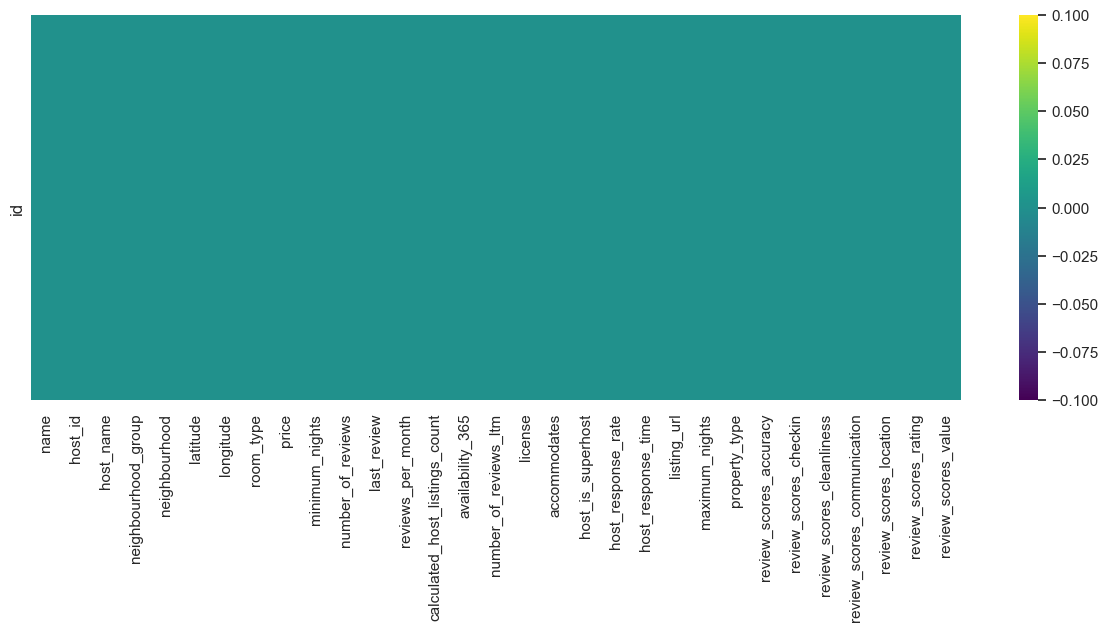

In [27]:
plt.figure(figsize=(15, 5))
sns.heatmap(oporto_imputed_decode.isnull(), yticklabels=False, cbar=True, cmap="viridis");

<font color='red'>OJO: muchos de estos valores de la columas de scores están imputados por -1 porque no ha habido forma de que el KNN los lograra rellenar bien o por NaN o NULL. El encoder trata los elementos vacíos y los encodea y luego a la vuelta del decoder esos valores el KNN no los ha tratado. Hay que pensar cómo mejorar la función __fritas__ para que no encodee los valores nulos y así el KNN pueda arreglarlos. <font>

In [28]:
oporto_imputed_decode.dtypes

name                               object
host_id                           float64
host_name                          object
neighbourhood_group                object
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          object
price                             float64
minimum_nights                    float64
number_of_reviews                 float64
last_review                        object
reviews_per_month                 float64
calculated_host_listings_count    float64
availability_365                  float64
number_of_reviews_ltm             float64
license                            object
accommodates                      float64
host_is_superhost                  object
host_response_rate                float64
host_response_time                 object
listing_url                        object
maximum_nights                    float64
property_type                     

In [29]:
oporto_imputed_decode = pd.DataFrame(oporto_imputed_decode).reset_index()

In [30]:
oporto_imputed_decode.to_csv("output/oporto_test_trimmed.csv", index=True, compression='infer', header=True, chunksize=10000, encoding='UTF-16', date_format=None)
# ? No sé ni qué hace esto, Demetrio...

In [31]:
oporto_imputed_decode

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,...,listing_url,maximum_nights,property_type,review_scores_accuracy,review_scores_checkin,review_scores_cleanliness,review_scores_communication,review_scores_location,review_scores_rating,review_scores_value
0,41339,Porto city flat near the sea,180050.0,Paula,PORTO,Lordelo do Ouro e Massarelos,41.150100,-8.660350,Entire home/apt,60.0,...,https://www.airbnb.com/rooms/41339,120.0,Entire rental unit,4.700000,4.85,4.900000,4.800000,4.550000,4.700000,4.650000
1,55111,Fontielas Houses |Floor1 in House with shared ...,259711.0,Isabel E João,PAREDES,Cete,41.174810,-8.353620,Entire home/apt,66.0,...,https://www.airbnb.com/rooms/55111,60.0,Entire rental unit,4.800000,4.87,4.670000,4.870000,4.790000,4.800000,4.790000
2,73828,Fontielas Houses |Floor0 in House with shared ...,259711.0,Isabel E João,PAREDES,Cete,41.174490,-8.354260,Entire home/apt,66.0,...,https://www.airbnb.com/rooms/73828,60.0,Entire rental unit,5.000000,5.00,4.830000,5.000000,4.920000,4.830000,4.750000
3,86388,A Formosa - a nest made for two,185209.0,João,PORTO,"Cedofeita, Ildefonso, Sé, Miragaia, Nicolau, V...",41.149180,-8.609220,Private room,33.0,...,https://www.airbnb.com/rooms/86388,31.0,Private room in rental unit,4.760000,4.93,4.650000,4.930000,4.870000,4.740000,4.760000
4,87873,Oporto Apartment Triplex,480980.0,Paula,PORTO,Bonfim,41.157860,-8.604270,Entire home/apt,64.0,...,https://www.airbnb.com/rooms/87873,14.0,Entire rental unit,4.870000,4.97,4.890000,4.940000,4.510000,4.790000,4.810000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12008,779127249810268197,Maria Home,55909094.0,Maria Jose,MATOSINHOS,São Mamede de Infesta e Senhora da Hora,41.193460,-8.608010,Entire home/apt,49.0,...,https://www.airbnb.com/rooms/779127249810268197,365.0,Entire rental unit,4.540000,4.68,4.550000,4.700000,4.670000,4.610000,4.533333
12009,779596413035604787,moradia geminada tipo t2,487257931.0,George,SANTA MARIA DA FEIRA,Sanguedo,41.016090,-8.516870,Entire home/apt,26.0,...,https://www.airbnb.com/rooms/779596413035604787,365.0,Entire home,4.833333,4.61,4.500000,4.610000,4.943333,4.890000,4.276667
12010,779712655687956624,Infante's Haven,409325747.0,Claudia & Mário,PORTO,"Cedofeita, Ildefonso, Sé, Miragaia, Nicolau, V...",41.141119,-8.614106,Entire home/apt,74.0,...,https://www.airbnb.com/rooms/779712655687956624,1125.0,Entire rental unit,4.946667,4.94,4.956667,4.986667,4.960000,4.926667,4.923333
12011,779753944728289358,Apartamento inteiro Porto,478851105.0,Marcelo E Breno,PORTO,Ramalde,41.168040,-8.654280,Entire home/apt,150.0,...,https://www.airbnb.com/rooms/779753944728289358,30.0,Entire rental unit,4.833333,4.90,4.900000,4.900000,4.833333,4.933333,4.866667


In [32]:
oporto_imputed_decode['latitude'].sort_values(ascending=False)

9815     41.455383
2009     41.442280
1738     41.436890
3885     41.436180
1323     41.435950
           ...    
10609    40.780530
8291     40.780100
8309     40.779770
11013    40.771790
6589     40.767490
Name: latitude, Length: 12013, dtype: float64

Para hacer bases de datos: 

Tampoco creo que esto me solucione el problema...

```python
import sqlite3

conn = sqlite3.connect('output/oporto.sqlite')

oporto_imputed_decode.to_sql('oporto', conn, if_exists='replace', index=False)

conn.close()
```

## 1.3. <a id='toc1_3_'></a>[Análisis exploratorio](#toc0_)

## 1.4. <a id='toc1_4_'></a>[Filtro de distancias](#toc0_)

La fórmula de Haversine es una fórmula matemática que se utiliza para calcular la distancia entre dos puntos en la superficie de una esfera, como la Tierra. La fórmula se basa en la longitud y la latitud de los dos puntos, y utiliza la ley de los cosenos para calcular la distancia entre ellos.

La fórmula de Haversine se puede expresar de la siguiente manera:

$$d = 2 R * \arcsin\left(\sqrt{\sin^2\left(\frac{lat_2-lat_1}{2}\right) + \cos(lat_1)\cos(lat_2)\sin^2\left(\frac{lon_2-lon_1}{2}\right)}\right)$$

donde:

- d es la distancia entre los dos puntos en la superficie de la esfera
- R es el radio de la esfera (en metros, kilómetros, millas, etc.)
- $lat_1$ y $lat_2$ son las latitudes de los dos puntos (en radianes o grados)
- $lon_1$ y $lon_2$ son las longitudes de los dos puntos (en radianes o grados)

In [33]:
df_distancia = filtrar_por_distancia(oporto_imputed_decode, 20)

In [34]:
df_55 = filtrar_por_distancia(oporto_imputed_decode,55)
df_55.to_csv('output/df_55.csv', index= True)

#* Este df va a servir para pasarlo a streamlit y en vez de pasar el oporto y la función de filtro por distancias directamente con el slider se seleccionarán los elementos del dataset con la distancia < a la fijada en el slider.

In [35]:
df_distancia

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,...,maximum_nights,property_type,review_scores_accuracy,review_scores_checkin,review_scores_cleanliness,review_scores_communication,review_scores_location,review_scores_rating,review_scores_value,distancia
0,41339,Porto city flat near the sea,180050.0,Paula,PORTO,Lordelo do Ouro e Massarelos,41.150100,-8.660350,Entire home/apt,60.0,...,120.0,Entire rental unit,4.700000,4.85,4.900000,4.800000,4.550000,4.700000,4.650000,4.140762
3,86388,A Formosa - a nest made for two,185209.0,João,PORTO,"Cedofeita, Ildefonso, Sé, Miragaia, Nicolau, V...",41.149180,-8.609220,Private room,33.0,...,31.0,Private room in rental unit,4.760000,4.93,4.650000,4.930000,4.870000,4.740000,4.760000,0.148215
4,87873,Oporto Apartment Triplex,480980.0,Paula,PORTO,Bonfim,41.157860,-8.604270,Entire home/apt,64.0,...,14.0,Entire rental unit,4.870000,4.97,4.890000,4.940000,4.510000,4.790000,4.810000,1.073178
5,91439,A Formosa 2 -The red sofa room,185209.0,João,PORTO,"Cedofeita, Ildefonso, Sé, Miragaia, Nicolau, V...",41.149080,-8.609050,Private room,35.0,...,1125.0,Private room in rental unit,4.860000,4.89,4.750000,4.930000,4.880000,4.780000,4.760000,0.165340
6,400134,Studio 4,1997241.0,Studios,PORTO,Bonfim,41.152150,-8.603750,Entire home/apt,67.0,...,30.0,Entire rental unit,4.330000,4.42,4.670000,4.330000,4.580000,4.180000,4.420000,0.662407
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12008,779127249810268197,Maria Home,55909094.0,Maria Jose,MATOSINHOS,São Mamede de Infesta e Senhora da Hora,41.193460,-8.608010,Entire home/apt,49.0,...,365.0,Entire rental unit,4.540000,4.68,4.550000,4.700000,4.670000,4.610000,4.533333,4.883005
12009,779596413035604787,moradia geminada tipo t2,487257931.0,George,SANTA MARIA DA FEIRA,Sanguedo,41.016090,-8.516870,Entire home/apt,26.0,...,365.0,Entire home,4.833333,4.61,4.500000,4.610000,4.943333,4.890000,4.276667,16.807851
12010,779712655687956624,Infante's Haven,409325747.0,Claudia & Mário,PORTO,"Cedofeita, Ildefonso, Sé, Miragaia, Nicolau, V...",41.141119,-8.614106,Entire home/apt,74.0,...,1125.0,Entire rental unit,4.946667,4.94,4.956667,4.986667,4.960000,4.926667,4.923333,0.980546
12011,779753944728289358,Apartamento inteiro Porto,478851105.0,Marcelo E Breno,PORTO,Ramalde,41.168040,-8.654280,Entire home/apt,150.0,...,30.0,Entire rental unit,4.833333,4.90,4.900000,4.900000,4.833333,4.933333,4.866667,4.170518


In [36]:
df_distancia['distancia'].describe().T

count    11146.000000
mean         2.254302
std          3.392367
min          0.011373
25%          0.611741
50%          0.971714
75%          2.005143
max         19.992239
Name: distancia, dtype: float64

In [37]:
df_distancia.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,...,maximum_nights,property_type,review_scores_accuracy,review_scores_checkin,review_scores_cleanliness,review_scores_communication,review_scores_location,review_scores_rating,review_scores_value,distancia
0,41339,Porto city flat near the sea,180050.0,Paula,PORTO,Lordelo do Ouro e Massarelos,41.15010,-8.66035,Entire home/apt,60.0,...,120.0,Entire rental unit,4.70,4.85,4.90,4.80,4.55,4.70,4.65,4.140762
3,86388,A Formosa - a nest made for two,185209.0,João,PORTO,"Cedofeita, Ildefonso, Sé, Miragaia, Nicolau, V...",41.14918,-8.60922,Private room,33.0,...,31.0,Private room in rental unit,4.76,4.93,4.65,4.93,4.87,4.74,4.76,0.148215
4,87873,Oporto Apartment Triplex,480980.0,Paula,PORTO,Bonfim,41.15786,-8.60427,Entire home/apt,64.0,...,14.0,Entire rental unit,4.87,4.97,4.89,4.94,4.51,4.79,4.81,1.073178
5,91439,A Formosa 2 -The red sofa room,185209.0,João,PORTO,"Cedofeita, Ildefonso, Sé, Miragaia, Nicolau, V...",41.14908,-8.60905,Private room,35.0,...,1125.0,Private room in rental unit,4.86,4.89,4.75,4.93,4.88,4.78,4.76,0.165340
6,400134,Studio 4,1997241.0,Studios,PORTO,Bonfim,41.15215,-8.60375,Entire home/apt,67.0,...,30.0,Entire rental unit,4.33,4.42,4.67,4.33,4.58,4.18,4.42,0.662407


In [38]:
df_distancia.dtypes

id                                  int64
name                               object
host_id                           float64
host_name                          object
neighbourhood_group                object
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          object
price                             float64
minimum_nights                    float64
number_of_reviews                 float64
last_review                        object
reviews_per_month                 float64
calculated_host_listings_count    float64
availability_365                  float64
number_of_reviews_ltm             float64
license                            object
accommodates                      float64
host_is_superhost                  object
host_response_rate                float64
host_response_time                 object
listing_url                        object
maximum_nights                    

In [39]:
df_distancia.count()

id                                11146
name                              11146
host_id                           11146
host_name                         11146
neighbourhood_group               11146
neighbourhood                     11146
latitude                          11146
longitude                         11146
room_type                         11146
price                             11146
minimum_nights                    11146
number_of_reviews                 11146
last_review                       11146
reviews_per_month                 11146
calculated_host_listings_count    11146
availability_365                  11146
number_of_reviews_ltm             11146
license                           11146
accommodates                      11146
host_is_superhost                 11146
host_response_rate                11146
host_response_time                11146
listing_url                       11146
maximum_nights                    11146
property_type                     11146


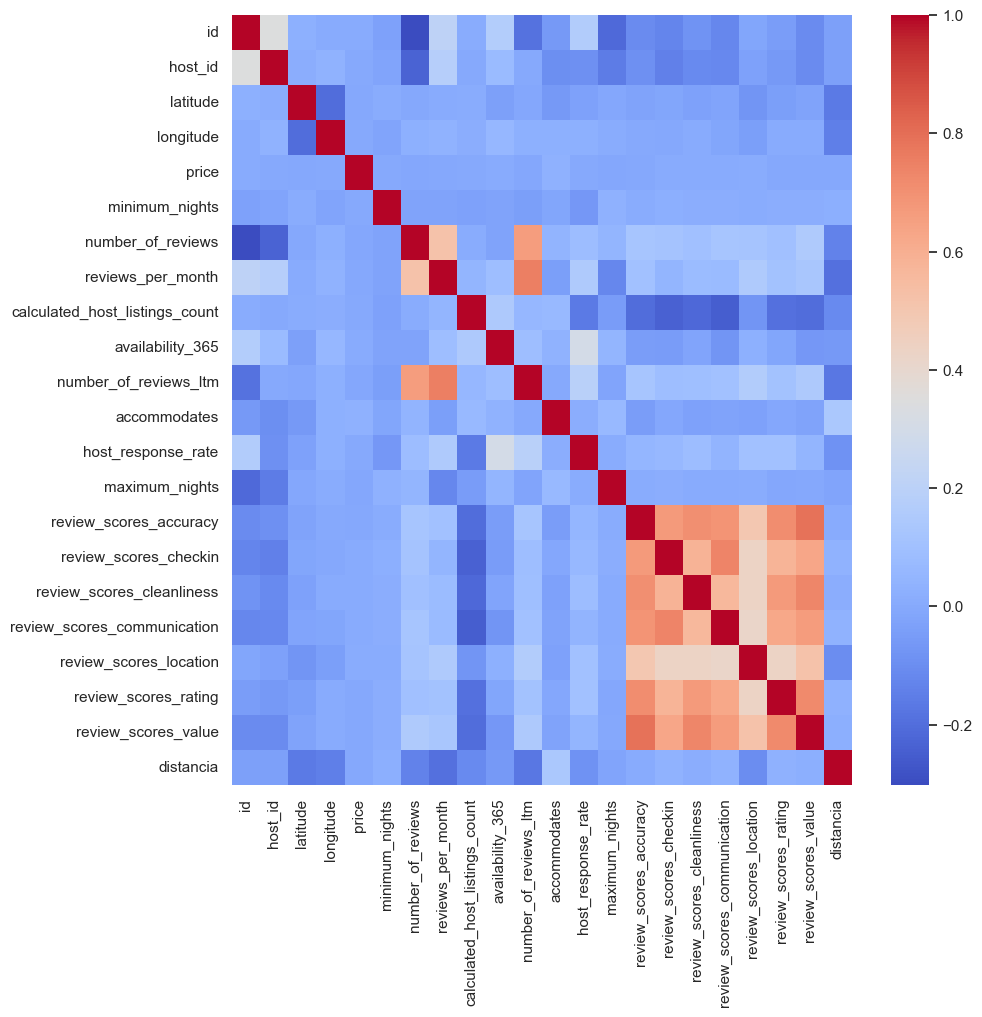

In [40]:
correlation_papa(df_distancia, annot=False)

### 1.4.1. <a id='toc1_4_1_'></a>[Vecindario (IGUAL NO DEBO PONER VECINDARIO sino parroquias o alguo así: freguesia)](#toc0_)

In [41]:
feq = oporto['neighbourhood'].value_counts().sort_values(ascending=True)
feq = feq[feq>500]

fig = px.bar(feq, x=feq.values, y=feq.index, orientation='h', template='plotly_dark')
fig.update_layout(
    title="Number of listings by neighbourhood",
    xaxis_title="Number of listings",
    yaxis_title="Neighbourhood",
    font=dict(size=12)
)
fig.show()

La Unión de las Parroquias de Cedofeita, Santo Ildefonso, Sé, Miragaia, São Nicolau e Vitória, también conocida como Unión de Parroquias del Centro Histórico de Oporto, es una parroquia portuguesa del municipio de Oporto, creada por la Ley n.º 11-A/2013 de 28 de enero, que une las antiguas parroquias de Cedofeita, Santo Ildefonso, Sé, Miragaia, São Nicolau y Vitória.

Tiene una superficie total de 5,43 km², una población de 37.436 habitantes (2021) y una densidad de población de 7.447,5 habitantes por km².

En resumen, la Unión de Parroquias de Cedofeita, Santo Ildefonso, Sé, Miragaia, São Nicolau e Vitória es una entidad administrativa portuguesa que se creó en 2013, que unió seis antiguas parroquias y ahora se conoce como la Unión de Parroquias del Centro Histórico de Oporto. La parroquia tiene una población de alrededor de 37.436 personas y una densidad de población bastante alta de 7.447,5 habitantes por km².

La palabra "freguesia" proviene del latín "filium ecclesiae", que significa "hijo de la iglesia". En Portugal, el antiguo Imperio Portugués y el Imperio de Brasil, una freguesia es la unidad administrativa más pequeña y obligatoria de los municipios, similar a una parroquia civil en otros países. Cada municipio tiene al menos una freguesia, y en algunos casos el territorio de una freguesia coincide con el del municipio.

### 1.4.2. <a id='toc1_4_2_'></a>[Mapa de la localización de los alojamientos](#toc0_)

In [42]:
lats = df_distancia['latitude'].tolist()
lons = df_distancia['longitude'].tolist()
locations = list(zip(lats, lons)) #Guardamos latitudes y longitudes, hacemos una tupla y las cambiamos a una lista.

map1 = folium.Map(location=[41.1496, -8.6109], zoom_start=12) # Le das una lat y lon inicial y un zoom inicial para representar el mapa
FastMarkerCluster(data=locations).add_to(map1) # Te añade las localizaciones al mapa generado anteriormente
folium.Marker(location=[41.1496, -8.6109]).add_to(map1)
map1

## 1.5. <a id='toc1_5_'></a>[Tipos de propiedades y habitaciones](#toc0_)

### 1.5.1. <a id='toc1_5_1_'></a>[Tipos de habitaciones](#toc0_)

Buscar info sobre ley en oporto 

_El tipo de habitación es muy importante en Ámsterdam, porque Ámsterdam tiene la regla de que las casas/apartamentos completos solo se pueden alquilar a través de Airbnb por un máximo de 60 días al año. A continuación, podemos ver que esta restricción se aplica a la mayoría de los listados._

In [43]:
freq = df_distancia['room_type'].value_counts().sort_values(ascending=True)

fig = px.bar(freq, orientation='h', color=freq.index,
             labels={'y': 'Room Type', 'x': 'Number of Listings'}, template='plotly_dark')
fig.update_layout(title="Number of Listings by Room Type",
                  xaxis_title="Number of Listings",
                  yaxis_title="Room Type",
                  height=400, width=800)
fig.show()

### 1.5.2. <a id='toc1_5_2_'></a>[Tipos de propiedades](#toc0_)

En el conjunto de datos, encontramos muchos tipos de propiedades diferentes.

In [44]:
df_distancia['property_type'].unique()

array(['Entire rental unit', 'Private room in rental unit',
       'Private room in home', 'Boat', 'Entire home', 'Tiny home',
       'Entire guesthouse', 'Private room in guesthouse', 'Entire loft',
       'Farm stay', 'Entire condo', 'Private room in condo',
       'Room in boutique hotel', 'Entire townhouse',
       'Entire serviced apartment', 'Private room in townhouse',
       'Private room in hostel', 'Shared room in hostel', 'Entire villa',
       'Shared room in bed and breakfast', 'Entire cottage', 'Windmill',
       'Entire cabin', 'Private room in guest suite', 'Camper/RV',
       'Room in hostel', 'Private room in bed and breakfast',
       'Private room in villa', 'Earthen home', 'Private room in cottage',
       'Private room in nature lodge', 'Shared room in home', 'Barn',
       'Shared room in rental unit', 'Private room in loft',
       'Private room in earthen home', 'Private room in boat',
       'Casa particular', 'Entire bungalow', 'Entire place',
       'Entire 

_Sin embargo, muchos de esos tipos de propiedades tienen muy pocos listados en Ámsterdam. En la figura a continuación, solo mostramos tipos de propiedades con al menos 100 listados. Como podemos ver, la gran mayoría de las propiedades en Ámsterdam son apartamentos._

In [45]:
prop = df_distancia.groupby(['property_type','room_type']).room_type.count()
prop = prop.unstack()
prop['total'] = prop.iloc[:,0:3].sum(axis = 1)
prop = prop.sort_values(by=['total'])
prop = prop[prop['total']>=100]
prop = prop.drop(columns=['total'])

fig = px.bar(prop, barmode='stack', orientation='h',
             color_discrete_sequence=["rgb(255, 102, 102)", "rgb(102, 178, 255)", "rgb(102, 255, 178)"],
             width=1000, height=600)
fig.update_layout(title='Property types in Oporto', xaxis_title='Number of listings', yaxis_title='',
                  legend_title='', font=dict(size=14), template='plotly_dark')
fig.show()

## 1.6. <a id='toc1_6_'></a>[Número de alojados](#toc0_)
_
Como era de esperar, la mayoría de los listados son para 2 personas. Además, Airbnb utiliza un máximo de 16 huéspedes por anuncio._

In [46]:
feq = df_distancia['accommodates'].value_counts().sort_index().reset_index()
feq.columns = ['Accommodates', 'Number of listings']
fig = px.bar(feq, x='Accommodates', y='Number of listings', 
             color='Accommodates',
             width=700, height=500, template='plotly_dark')
fig.update_layout(title={'text':"Accommodates (number of people)", 'x':0.5},
                  xaxis_title='Accommodates', yaxis_title='Number of listings',
                  font=dict(size=14))
fig.show()

_Sin embargo, Ámsterdam tiene una restricción adicional. Debido a las consideraciones de riesgo de incendio y también teniendo en cuenta un posible grupo ruidoso, los propietarios solo pueden alquilar su propiedad a grupos con un máximo de 4 personas. ¡Esto realmente significa que las listas que indican que el número máximo de personas es superior a 4 están infringiendo esta regla!_

In [47]:
df_distancia[df_distancia['accommodates']>15].head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,...,maximum_nights,property_type,review_scores_accuracy,review_scores_checkin,review_scores_cleanliness,review_scores_communication,review_scores_location,review_scores_rating,review_scores_value,distancia
539,5824521,House for conference groups in Porto,30231944.0,Sara,PORTO,Bonfim,41.14895,-8.60177,Entire home/apt,454.0,...,1125.0,Entire home,4.93,4.94,4.92,4.93,4.89,4.89,4.80,0.767860
669,6151673,"LVPremier Clerigos RE2- space, lift, AC, balcony",181902.0,Jose Luz,PORTO,"Cedofeita, Ildefonso, Sé, Miragaia, Nicolau, V...",41.14607,-8.62058,Entire home/apt,238.0,...,1125.0,Entire rental unit,4.89,4.93,4.84,4.84,4.78,4.76,4.66,0.900562
1054,10605132,River&Seaview House Casa do Gólgota,27267172.0,Marcos,PORTO,Lordelo do Ouro e Massarelos,41.14874,-8.63418,Entire home/apt,675.0,...,1125.0,Entire home,4.96,4.87,4.92,4.80,4.81,4.96,4.81,1.951571
1626,14269952,3-Storey House in the Heart of Foz do Douro,25193912.0,Jorge,PORTO,"Aldoar, Foz do Douro e Nevogilde",41.15366,-8.67376,Entire home/apt,657.0,...,1125.0,Entire home,4.94,5.00,4.94,4.94,4.83,5.00,5.00,5.282376
1926,16803834,Downtown Garden Terrace 22pax.,625145.0,Manuel & Family,PORTO,Bonfim,41.15306,-8.60328,Entire home/apt,246.0,...,1125.0,Entire villa,4.40,4.45,4.40,4.24,4.52,4.35,4.25,0.745026


## 1.7. <a id='toc1_7_'></a>[Analítica al servicio del gobierno. (PENDIENTE DE REVISAR LA LEY DE OPORTO )](#toc0_)

## 1.8. <a id='toc1_8_'></a>[Consejos al turismo](#toc0_)

### 1.8.1. <a id='toc1_8_1_'></a>[Precio medio por vecindario](#toc0_)

_Para comparar "manzanas con manzanas" solo seleccionaremos el tipo de alojamiento más común, que es el alojamiento para 2 personas. Como era de esperar, el alojamiento en el centro de la ciudad es el más caro._

In [48]:
feq = df_distancia[df_distancia['accommodates']==2]
feq = feq.groupby('neighbourhood')['price'].mean().sort_values(ascending=True)

fig = px.bar(feq, orientation='h', width=800, height=1200, color=feq.values,
             color_continuous_scale='RdYlGn_r', labels={'y':'Neighbourhood', 'x':'Average daily price (Euro)'},
             title='Average daily price for a 2-persons accommodation', template='plotly_dark')

fig.update_layout(template='plotly_dark')
fig.show()

#### 1.8.1.1. <a id='toc1_8_1_1_'></a>[Mapa del precio medio por localizaciones](#toc0_)

In [49]:
# Read in data
porto_geojson = "http://data.insideairbnb.com/portugal/norte/porto/2022-12-16/visualisations/neighbourhoods.geojson"
porto_gdf = gpd.read_file(porto_geojson)


<font color = 'red'> Comentado todo este mapa porque es una auténtica locura lo que a veces tarda en ejecutarse.</font>

In [50]:

# Calculate mean price by neighborhood for listings that accommodate 2 people
mean_prices = df_distancia.loc[df_distancia['accommodates'] == 2].groupby('neighbourhood')['price'].mean()

# Join the mean prices to the geojson
porto_gdf = porto_gdf.join(mean_prices, on='neighbourhood')

# Drop neighborhoods without mean prices
porto_gdf.dropna(subset=['price'], inplace=True)

# Round the mean prices and create a dictionary for the color map
price_dict = porto_gdf.set_index('neighbourhood')['price'].round().to_dict()

# Define color map
color_scale = LinearColormap(['green', 'yellow', 'red'], vmin=min(price_dict.values()), vmax=max(price_dict.values()), caption='Average price')

# Define style and highlight functions
def style_function(feature):
    return {
        'fillColor': color_scale(price_dict.get(feature['properties']['neighbourhood'], 0)),
        'color': 'black',
        'weight': 1,
        'dashArray': '5, 5',
        'fillOpacity': 0.5
    }

def highlight_function(feature):
    return {
        'weight': 3,
        'fillColor': color_scale(price_dict.get(feature['properties']['neighbourhood'], 0)),
        'fillOpacity': 0.8
    }

# Create map
map3 = folium.Map(location=[41.1496, -8.6109], zoom_start=11)

# Add geojson layer to map with tooltip and style and highlight functions
folium.GeoJson(
    data=porto_gdf,
    name='Oporto',
    tooltip=folium.features.GeoJsonTooltip(fields=['neighbourhood', 'price'], labels=True, sticky=False),
    style_function=style_function,
    highlight_function=highlight_function
).add_to(map3)

# Add marker to map
folium.Marker(location=[41.1496, -8.6109]).add_to(map3)

# Add color scale to map
map3.add_child(color_scale)





# contador = 0 
# "tu bucle for"
# contador += 1
# if contador > 99 #pordeciralgo:
#      print(f"límite alcanzado")
#      break 

#### 1.8.1.2. <a id='toc1_8_1_2_'></a>[Veamos el tipo de vivienda a alquilar por colores y localizaciones](#toc0_)

<font color = 'red'> Ahora dice que no hay room_type en el df_distancia o que no puede acceder a la posición 0 del diccionario... no me queda claro </font>

In [51]:
map_type = folium.Map(location=[41.1496, -8.6109], zoom_start=11)

# Creamos colorines para cada tipo de habitación
colors = {'Entire home/apt': 'orange', 'Private room': 'red', 'Shared room': 'purple', 'Hotel room': 'green'}

def room_type_icon(room_type):
    color = colors.get(room_type, 'blue')
    return folium.Icon(color=color, icon_color=color, prefix='fa', icon='circle')

# Añadir un marcador para cada habitación
for i in range(len(df_distancia)):
    room_type = df_distancia['room_type'][i]
    latitude = df_distancia['latitude'][i]
    longitude = df_distancia['longitude'][i]
    color = colors.get(room_type, 'blue')
    icon = room_type_icon(room_type)
    # Añadir el marcador al mapa
    folium.Marker(location=[latitude, longitude], icon=icon, popup=room_type).add_to(map_type)

# el html mejor así


legend = folium.features.DivIcon(html=legend_html)
folium.Marker(location=[41.1496, -8.6109], icon=legend).add_to(map_type)

# Mostramos mapa
map_type

KeyError: 1

In [ ]:
# con esto vamos a crear una agrupación automática según los marcadores cercanos basado en el tipo de habitación para mejorar la carga.
map_type = folium.Map(location=[41.1496, -8.6109], zoom_start=11)

# Creamos colorines para cada tipo de habitación
colors = {'Entire home/apt': 'orange', 'Private room': 'red', 'Shared room': 'purple', 'Hotel room': 'green'}

def room_type_icon(room_type):
    color = colors.get(room_type, 'blue')
    return folium.Icon(color=color, icon_color=color, prefix='fa', icon='circle')

# Crear una lista vacía para las coordenadas y datos de las habitaciones
room_data = []
for i in range(len(df_distancia)):
    room_type = df_distancia['room_type'][i]
    latitude = df_distancia['latitude'][i]
    longitude = df_distancia['longitude'][i]
    color = colors.get(room_type, 'blue')
    # Añadir la información de la habitación a la lista
    room_data.append([latitude, longitude, room_type, color])

# Usar FastMarkerCluster para agrupar los marcadores de habitaciones cercanas basados en el tipo de habitación
marker_cluster = FastMarkerCluster(room_data, callback=""" function (row) { var icon = L.AwesomeMarkers.icon({ icon: 'circle', prefix: 'fa', markerColor: row[3], iconColor: row[3] }); var marker = L.marker(new L.LatLng(row[0], row[1]), {icon: icon}); marker.bindPopup(row[2]); return marker; } """)
marker_cluster.add_to(map_type)

# el html mejor así
legend_html = ''' 
<div style="bottom: 30px; 
            right: 30px;
            width: 120px; 
            height: 200px; 
            border:2px solid grey; 
            z-index:9999; 
            font-size:14px; 
            background-color: rgba(255, 255, 255, 0.7); ">
    <p style="margin: 10px;"><b>Legend</b></p>
    <p style="margin: 10px;"><span style='color: orange;'>&#9679;</span> Entire home/apt</p>
    <p style="margin: 10px;"><span style='color: red;'>&#9679;</span> Private room</p>
    <p style="margin: 10px;"><span style='color: purple;'>&#9679;</span> Shared room</p>
    <p style="margin: 10px;"><span style='color: green;'>&#9679;</span> Hotel room</p>
</div>
'''

legend = folium.features.DivIcon(html=legend_html)
folium.Marker(location=[41.1496, -8.6109], icon=legend).add_to(map_type)

# Mostramos mapa
map_type
# TODO HAY QUE HACER QUE LA LEYENDA SE COLOQUE EN SU PUTO SITIO DE UNA VEZ

#### 1.8.1.3. <a id='toc1_8_1_3_'></a>[Qué áreas de Oporto serán las más rentables para alquilar](#toc0_)

Basándonos en las localizaciones más turísticas de la ciudad de Oporto haremos una correlación con el precio para poder determinar cuáles son las zonas más rentables para tener un Airbnb.

#### 1.8.1.4. <a id='toc1_8_1_4_'></a>[Mapa de calor con los precios más altos](#toc0_)

In [ ]:
# Mapa de calor basándome en uno de Demetrio

# Get the minimum and maximum price values
min_price = df_distancia['price'].min()
max_price = df_distancia['price'].max()
# Define the color scale for the legend
color_scale = LinearColormap(['green', 'yellow', 'red'], vmin=min_price, vmax=max_price, caption='Precio')




# Create the map
calorsita = folium.Map(location=[41.1496, -8.6109], tiles='cartodbpositron', zoom_start=12)

# Add a heatmap to the base map
HeatMap(data=df_distancia[['latitude', 'longitude', 'price']],
        radius=20,
        gradient={0.2: 'green', 0.5: 'yellow', 1: 'red'},
        min_opacity=0.2).add_to(calorsita)

# Add the color scale legend
calorsita.add_child(color_scale)


# Display the map
calorsita


### 1.8.2. <a id='toc1_8_2_'></a>[Sobre la movidita de los pisos de AirBnB en Portugal.](#toc0_)

- https://www.elmundo.es/economia/2018/07/18/5b4e2989ca47411d0c8b4572.html
- Igual estaría bueno bajarse los datos de años anteriores para ver la comparativa de *aumento de pisos de airbnb*

https://www.elmundo.es/economia/2018/07/18/5b4e2989ca47411d0c8b4572.html

### 1.8.3. <a id='toc1_8_3_'></a>[Seguridad del vecindario](#toc0_)

### 1.8.4. <a id='toc1_8_4_'></a>[Review scores location, and location scores versus price](#toc0_)

En esta sección, agrupamos los puntajes de revisión de la ubicación por vecindario (solo listados con al menos 10 revisiones). Aunque esperamos que la distancia al centro de la ciudad sea un factor importante, esta puntuación también debería tener en cuenta otras cosas. Otros factores pueden incluir:

* La seguridad de una ubicación (como se muestra en la sección anterior)
* Ruido. Si una lista tiene una ubicación central, pero está rodeada de bares ruidosos, eso debería costar puntos en el puntaje de revisión de la ubicación.
* Si un listado está ubicado fuera del centro de la ciudad pero bien conectado por transporte público, debería obtener puntos de bonificación por eso.
* Instalaciones cercanas al listado. ¿Hay supermercados, bares y restaurantes cerca?
* Puede que algunas personas busquen aparcamiento gratuito si vienen en coche (el aparcamiento es muy caro en Ámsterdam en general).

A continuación, vemos que los vecindarios centrales, que generalmente también fueron los más caros, generalmente también obtienen una puntuación más alta en la puntuación de revisión de ubicación. Si calculara la distancia al centro de la ciudad para cada listado, espero ver correlaciones bastante fuertes entre esta distancia con el puntaje de revisión del precio y la ubicación.

Al mirar el puntaje promedio de revisión, me sorprende ver que el promedio está por encima de 8/10 para todos los vecindarios. Ámsterdam es una ciudad pequeña (¡mucho más pequeña de lo que mucha gente piensa!). Por lo tanto, no lleva mucho tiempo llegar al centro de la ciudad desde cualquier lugar, lo que podría explicar hasta cierto punto los altos promedios. Mi consejo personal para los turistas sería considerar un alojamiento más asequible fuera del centro de la ciudad, en un vecindario seguro y con buenas conexiones de transporte público al centro de la ciudad de todos modos. Sin embargo, ¿las diferencias entre las mejores ubicaciones y los vecindarios exteriores son realmente tan pequeñas? ¡Vamos a averiguarlo en la siguiente sección!


In [ ]:
# Group by neighbourhood and calculate the mean review score location for listings with at least 10 reviews
feq1 = df_distancia[df_distancia['number_of_reviews'] >= 10].groupby('neighbourhood')['review_scores_location'].mean().sort_values(ascending=True)

# Create bar chart using Plotly Express
fig1 = px.bar(feq1, x='review_scores_location', y=feq1.index, orientation='h', color='review_scores_location', color_continuous_scale='RdYlGn')
fig1.update_layout(xaxis_title="Score (scale 1-10)", yaxis_title="") # TODO CUIDADO CON EL COLOR!!!!

# Group by neighbourhood and calculate the mean daily price for 2-person accommodations
feq2 = df_distancia[df_distancia['accommodates'] == 2].groupby('neighbourhood')['price'].mean().sort_values(ascending=True)

# Create bar chart using Plotly Express
fig2 = px.bar(feq2, x='price', y=feq2.index, orientation='h', color='price', color_continuous_scale='viridis')
fig2.update_layout(xaxis_title="Average daily price (Euro)", yaxis_title="")

# Combine the two charts into a single subplot
figures = sp.make_subplots(rows=2, cols=1, subplot_titles=("Average review score location (at least 10 reviews)", "Average daily price for a 2-persons accommodation"))

# Add each bar chart to the subplot
figures.add_trace(fig1['data'][0], row=1, col=1)
figures.add_trace(fig2['data'][0], row=2, col=1)

# Update the layout of the subplot
figures.update_layout(
    title_text="Locations",
    height=800,
    width=1000,
    font_size=12,
    showlegend=False, 
    template = 'plotly_dark'
)
# TODO CUIDADO CON LA BARRA DE COLORES

## 1.9. <a id='toc1_9_'></a>[Cómo usar las puntuaciones de las opiniones](#toc0_)

Además de las reseñas escritas, los invitados pueden enviar una calificación de estrellas general y un conjunto de calificaciones de estrellas de categoría. Los huéspedes pueden dar calificaciones sobre:

* Experiencia general. ¿Cuál fue su experiencia en general?
* Limpieza. ¿Sentiste que tu espacio estaba limpio y ordenado?
* Precisión. ¿Con qué precisión su página de listado representó su espacio?
* Valor. ¿Sintió que su listado proporcionó un buen valor por el precio?
* Comunicación. ¿Qué tan bien se comunicó con su anfitrión antes y durante su estadía?
* Llegada. ¿Qué tan bien fue su registro?
* Ubicación. ¿Cómo te sentiste en el barrio?

A continuación puede ver la distribución de puntajes de todas esas categorías. ¡Lo que me llamó la atención de inmediato es que las puntuaciones parecen realmente altas en todos los ámbitos!. Está bien explicado en este artículo: [¿Más alta que la calificación promedio? El 95 % de los listados de Airbnb calificaron de 4,5 a 5 estrellas](https://mashable.com/2015/02/25/airbnb-reviews-above-average/?europe=true#1YLfzOC34sqd).

Después de haber visto las distribuciones de puntajes, personalmente consideraría que cualquier puntaje de 8 o inferior no es un buen puntaje.

In [ ]:
df_distancia.shape

In [ ]:
# Select listings with at least 10 reviews
listings10 = df_distancia[df_distancia['number_of_reviews']>=10]

# Create histogram figures for each review category
fig1 = px.histogram(listings10, x='review_scores_location',
             barmode='group', category_orders={'review_scores_location': sorted(listings10['review_scores_location'].unique())})
fig1.update_layout(title="Location", xaxis_title="Average review score", yaxis_title="Number of listings", font_size=14)

fig2 = px.histogram(listings10, x='review_scores_cleanliness',
              barmode='group', category_orders={'review_scores_cleanliness': sorted(listings10['review_scores_cleanliness'].unique())})
fig2.update_layout(title="Cleanliness", xaxis_title="Average review score", yaxis_title="Number of listings", font_size=14)

fig3 = px.histogram(listings10, x='review_scores_value',
              barmode='group', category_orders={'review_scores_value': sorted(listings10['review_scores_value'].unique())})
fig3.update_layout(title="Value", xaxis_title="Average review score", yaxis_title="Number of listings", font_size=14)

fig4 = px.histogram(listings10, x='review_scores_communication',
              barmode='group', category_orders={'review_scores_communication': sorted(listings10['review_scores_communication'].unique())})
fig4.update_layout(title="Communication", xaxis_title="Average review score", yaxis_title="Number of listings", font_size=14)

fig5 = px.histogram(listings10, x='review_scores_checkin',
              barmode='group', category_orders={'review_scores_checkin': sorted(listings10['review_scores_checkin'].unique())})
fig5.update_layout(title="Arrival", xaxis_title="Average review score", yaxis_title="Number of listings", font_size=14)

fig6 = px.histogram(listings10, x='review_scores_accuracy',
              barmode='group', category_orders={'review_scores_accuracy': sorted(listings10['review_scores_accuracy'].unique())})
fig6.update_layout(title="Accuracy", xaxis_title="Average review score", yaxis_title="Number of listings", font_size=14)

# Create subplot with 2 rows and 3 columns, with titles for each subplot
figs = sp.make_subplots(rows=2, cols=3, subplot_titles=("Location", "Cleanliness", "Value", "Communication", "Arrival", "Accuracy"))

# Add each bar chart to the subplot
figs.add_trace(fig1['data'][0], row=1, col=1)
figs.add_trace(fig2['data'][0], row=1, col=2)
figs.add_trace(fig3['data'][0], row=1, col=3)
figs.add_trace(fig4['data'][0], row=2, col=1)
figs.add_trace(fig5['data'][0], row=2, col=2)
figs.add_trace(fig6['data'][0], row=2, col=3)

# Update layout for the subplot
figs.update_layout(
    title_text="Review Scores",
    height=800,
    width=1000,
    font_size=12,
    showlegend=False
)
# TODO INTENTAR PONER EL COLOR DE LAS REVIEWS
# Show

### 1.9.1. <a id='toc1_9_1_'></a>[Encontrando un buen hospedador](#toc0_)



En Airbnb puedes obtener el estatus de "Superhost". De Airbnb:
* Como SuperAnfitrión, tendrá más visibilidad, potencial de ingresos y recompensas exclusivas. Es nuestra manera de decir gracias por su hospitalidad excepcional.
* Cómo convertirse en Superhost: cada 3 meses, verificamos si cumple con los siguientes criterios. Si lo haces, ganarás o mantendrás tu estatus de SuperAnfitrión.
    * Los Superanfitriones tienen una calificación general promedio de 4.8 o superior según las reseñas de al menos el 50 % de sus huéspedes de Airbnb durante el último año.
    * Los Superhosts han alojado al menos 10 estadías en el último año o, si realizan reservas a más largo plazo, 100 noches en al menos 3 estadías.
    * Los Superhosts no tienen cancelaciones en el último año, a menos que haya circunstancias atenuantes.
    * Los Superhosts responden al 90 % de los mensajes nuevos en 24 horas.

A continuación, podemos ver que solo una pequeña parte de los listados en Ámsterdam tienen un anfitrión que es Superanfitrión.

In [ ]:
df_frequencies = df_distancia['host_is_superhost'].value_counts(normalize=True).reset_index()
df_frequencies.columns = ['Superhost', 'Percentage']
df_frequencies['Percentage'] = df_frequencies['Percentage'] * 100

fig = px.bar(df_frequencies, x='Superhost', y='Percentage',
             labels={'Superhost': 'Superhost', 'Percentage': 'Percentage (%)'},
             color='Superhost',
             color_discrete_map={'f': 'rgb(255, 0, 0)', 't': 'rgb(0, 128, 0)'})

fig.update_traces(texttemplate='%{y:.2f}%', textposition='inside')
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')
fig.update_layout(legend_title='Superhost', legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1))

fig.update_layout(
    title_text="Percentage of Superhost",
    height=400,
    width=1000,
    font_size=12,
    showlegend=False
)

Si tuviéramos que reservar alojamiento, no buscaríamos necesariamente un superhost. En realidad, me temo que pagaría demasiado, ya que el superhost probablemente aumentará sus precios. Sin embargo, tampoco me gustaría un host que responde mal o cancela mucho.

Como podemos ver, más de 5.000 de los 20.000 listados tienen al menos 10 reseñas y responden al menos al 90% de los mensajes nuevos. Consideraría que esos anfitriones son buenos respondedores "probados" (lo que no significa que una lista con menos de 10 reseñas no pueda tener buenos anfitriones que respondan; simplemente no está probado todavía). Además, hay muy pocos listados con anfitriones que no respondan a los mensajes nuevos dentro de las 24 horas.

In [ ]:
listings10 = df_distancia[df_distancia['number_of_reviews'] >= 10]
feq1 = listings10['host_response_rate'].replace(0, np.nan).dropna().sort_values(ascending=True) #Cambiamos los valores 0 con los que rellenamos al principio por nan para poder droppearlos

fig1 = px.histogram(feq1, nbins=35)
fig1.update_layout(title='Response rate (at least 10 reviews)', xaxis_title='Percent', yaxis_title='Number of Listings', font=dict(size=20))

#TODO Arreglar el gráfico 1 para que los límites de los ejes tengan sentido.

fig2 = px.bar(listings10.dropna(subset=['host_response_time'])['host_response_time'].value_counts().reset_index(), 
              x='index', y='host_response_time', labels={'index': 'Response time', 'host_response_time': 'Number'})
fig2.update_layout(title='Response time (at least 10 reviews)', xaxis_title_font_size=20, 
                   yaxis_title_font_size=20, font=dict(size=16))


# Create subplot with 2 rows and 3 columns, with titles for each subplot
figs = sp.make_subplots(rows=1, cols=2, subplot_titles=("Response rate", "Response time"))

# Add each bar chart to the subplot
figs.add_trace(fig1['data'][0], row=1, col=1)
figs.add_trace(fig2['data'][0], row=1, col=2)

# Update layout for the subplot
figs.update_layout(
    title_text="Responses",
    height=400,
    width=1000,
    font_size=12,
    showlegend=False
)


## 1.10. <a id='toc1_10_'></a>[Disponibilidad en el tiempo](#toc0_)

El archivo de calendario contiene 365 registros para cada listado, lo que significa que para cada listado, el precio y la disponibilidad por fecha se especifican con 365 días de anticipación.

In [ ]:
df_calendar.price = df_calendar.price.str.replace(",","")
df_calendar['price'] = pd.to_numeric(df_calendar['price'].str.strip('$'))
#df_calendar = df_calendar[df_calendar.date < '2023-1-1']

In [ ]:
print(df_calendar.shape)

In [ ]:
df_calendar.head()

In [ ]:
df_distancia.head()

A continuación se muestra un ejemplo de los datos del calendario. Importante tener en cuenta: la disponibilidad es FALSE significa que el propietario no quiere alquilar su propiedad en la fecha específica o que la lista ya se ha reservado para esa fecha. Como queremos comparar manzanas con manzanas nuevamente con respecto a los precios en la siguiente sección, estamos fusionando la variable 'accomodate' con el calendario.

In [ ]:
df_calendar = pd.merge(df_distancia, df_calendar, left_on='id', right_index=True)

In [ ]:
df_calendar.head()

A continuación, vemos que hasta tres meses por delante, generalmente hay más alojamientos disponibles que en el futuro. Las razones de esto pueden ser que los anfitriones están actualizando más activamente sus calendarios en este período de tiempo. Este gráfico es **interactivo** y, al pasar el cursor sobre los puntos, se mostrará una información sobre herramientas con el "número de listados disponibles" y el "día de la semana" por fecha.

In [ ]:
# Leer los datos y convertir la columna 'date' en tipo datetime
df_calendar['date'] = pd.to_datetime(df_calendar['date'])

# Filtrar los datos para tener sólo los disponibles
sum_available = df_calendar[df_calendar.available == "t"].groupby(['date']).size().to_frame(name= 'available').reset_index()

# Agregar la columna de día de la semana
sum_available['weekday'] = sum_available['date'].dt.day_name()

# Establecer 'date' como el índice del DataFrame
sum_available = sum_available.set_index('date')

# Crear la figura de Plotly Express
fig = px.line(sum_available, y='available', title='Number of listings available by date')

# Mostrar la figura
fig.show()

### 1.10.1. <a id='toc1_10_1_'></a>[Precio medio por día](#toc0_)



A continuación, verá el precio promedio de todos los alojamientos para 2 personas marcados como disponibles por fecha. El pico del precio promedio de 240 euros es el 31 de diciembre y el patrón cíclico se debe a precios más altos en los fines de semana. Sin embargo, sospecho que los precios para fechas más lejanas en el tiempo aún no están actualizados y probablemente sean precios predeterminados. Esto podría dar lugar a que el anfitrión no acepte una reserva si se da cuenta de que alguien está intentando reservar algo en una fecha que debería haber sido más cara de lo habitual. Este gráfico es **interactivo** y, al pasar el cursor sobre los puntos, se mostrará una información sobre herramientas con el precio promedio y el día de la semana por fecha.

In [ ]:
df_calendar

In [ ]:
average_price = df_calendar[(df_calendar.available == "t") & (df_calendar.accommodates == 2)].groupby(['date']).mean().astype(np.int64).reset_index()
average_price['weekday'] = average_price['date'].dt.day_name()
average_price = average_price.set_index('date')

In [ ]:
fig = px.line(average_price, x=average_price.index, y='price_x', title='Average price of available 2 persons accommodation by date')
fig.update_traces(text=average_price['weekday'])
fig.update_layout(xaxis_title='Date', yaxis_title='Price')
fig.show()

## 1.11. <a id='toc1_11_'></a>[Minería de texto con las reviews](#toc0_)

Veamos ahora cómo podríamos obtener algo de información extra de las opiniones de los usuarios, en términos muy elementales. Esta sección es un preliminar muy introductorio y básico de un amplio área de estudio conocida como *topic modelling*.

El archivo de "reviews" resultó no ser muy interesante, ya que solo contiene fechas de revisión para cada listado, lo que significa que solo es bueno para contar el número de revisiones. El archivo "reviews_details" contiene la misma información (y la misma cantidad de registros), con 4 columnas adicionales. Además, fusionamos host_id y host_names de la lista con el archivo reviews_details.

In [ ]:
df_reviews = pd.merge(df_reviews, df_oporto_review[['host_id', 'host_name', 'name']], left_on = "listing_id", right_index=True, how = "left")
df_reviews = df_reviews.set_index('id')
df_reviews = df_reviews[['listing_id', 'name', 'host_id', 'host_name', 'date', 'reviewer_id', 'reviewer_name', 'comments']]
df_reviews

A continuación, encontrará los 5 hosts con más reseñas. _Es interesante ver de nuevo los nombres de los anfitriones Martijn y Feliciano, que ya se han discutido antes._

In [ ]:
host_reviews = df_reviews.groupby(['host_id', 'host_name']).size().sort_values(ascending=False).to_frame(name = "number_of_reviews")
host_reviews.head()

In [ ]:
df_reviews.comments.head()

In [ ]:
# take out empty comments (530)
df_reviews = df_reviews[df_reviews['comments'].notnull()]

# remove non-alphanumeric characters and make everything lowercase
df_reviews['comments'] = df_reviews['comments'].str.replace('[^a-zA-Z0-9\sáéíóúÁÉÍÓÚñÑçÇ\~]+', '').str.lower()

# remove windows new line
df_reviews['comments'] = df_reviews['comments'].str.replace('\r\n', "")

# remove stopwords (from nltk library)
stop_words = []
for language in ["english", "spanish", "french", "portuguese"]:
    stop_words.extend(stopwords.words(language))
df_reviews['comments'] = df_reviews['comments'].apply(lambda x: " ".join([i for i in x.split() if i not in stop_words]))

# remove punctuation and replace x spaces by one space
df_reviews['comments'] = df_reviews['comments'].str.replace('[^\w\s]'," ").str.replace('\s+', ' ')

df_reviews.comments.values[2] # print same comments again


In [ ]:
texts = df_reviews.comments.tolist()

vec = CountVectorizer().fit(texts)
bag_of_words = vec.transform(texts)
sum_words = bag_of_words.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]

cvec_df = pd.DataFrame.from_records(words_freq, columns= ['words', 'counts']).sort_values(by="counts", ascending=False)
cvec_df.head(10)

In [ ]:
cvec_dict = dict(zip(cvec_df.words, cvec_df.counts))

wordcloud = WordCloud(width=800, height=400)
wordcloud.generate_from_frequencies(frequencies=cvec_dict)
plt.figure( figsize=(20,10) )
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad = 0)
plt.savefig('img/wordcloud.png')
plt.show()

## 1.13. <a id='toc1_13_'></a>[Modelos predictivos para predecir el valor de tu alojamiento en Oporto.](#toc0_)

Target será price y el resto de columnas serán las features, pero supongo que aquí solo entran como features

Basándome en el modelo predicctivo de Demetrio

In [ ]:
df_distancia.columns

He usado PyCatet como he sabido para evaluar las mejores features, éstas serán de entre las columnas que voy a elegir como features, aunque parece ser que eso no garantiza una buena predicción del modelo.



![pycaret features2](img/SCR-20230330-twit.png)

In [ ]:
df = df_distancia[['neighbourhood', 'property_type', 'room_type', 'minimum_nights', 'price', 'accommodates', 'review_scores_cleanliness', 'review_scores_location', 'host_is_superhost']]


In [ ]:
from pycaret.regression import *
setup(data = df , target = 'price')

In [ ]:
compare_models(fold= 10)

In [ ]:
from sklearn.linear_model import HuberRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from sklearn.preprocessing import LabelEncoder 



#encodeasion a df 
encoder = LabelEncoder()
def encodeando(typeEncode):
    df[typeEncode] = encoder.fit_transform(df[typeEncode])

encodeando('neighbourhood')
encodeando('property_type')
encodeando('room_type')
encodeando('host_is_superhost')
#sacamos los outliers con el rango intercuartil
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

df = df[~((df < (Q1 - 1.5 * IQR)) |
            (df > (Q3 + 1.5 * IQR))).any(axis=1)]


#Normalizamos los datos 
df.price=(df.price-df.price.min())/(df.price.max()-df.price.min())



# Definimos los X e y
X = df.drop(['price'], axis=1)
y = df['price']

#Dividimos en datos de entrenamiento y de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=357)

#Entrenamos un modelo predictivo con Regresión Linear
modelo = HuberRegressor()
modelo.fit(X_train, y_train)

pred = modelo.predict(X_test)


X_sm = X = sm.add_constant(X)
model = sm.OLS(y, X_sm)
est = model.fit()
print(est.summary())

In [ ]:
import math
from sklearn.metrics import mean_squared_error
MSE = mean_squared_error(y_test, pred)
RMSE = math.sqrt(MSE)
print(RMSE)

0.16 creo que quiere decir que se desvía un 16% del valor real, lo cual para ser la primera vez que hago esta movida no está mal. 
(Igual es que acierta un 16% lo cual es una auténtica basura)

### 1.13.1. <a id='toc1_13_1_'></a>[Fast Machine Learning con Pycaret -> Claramente no sé usar Pycaret.](#toc0_)

In [ ]:
s = setup(df_distancia, target= 'price', session_id=42)

In [ ]:
best = compare_models()

In [ ]:
evaluate_model(best)

In [ ]:
print(best)

In [ ]:
plot_model(best, plot='residuals')

In [ ]:
predict_model(best)